In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.inceptionv3 import inceptionv3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'train'
valid_path = 'val'
test_path = 'test'

In [4]:
# useful for getting number of output classes
folders = glob('train/*')

In [5]:
folders

['train\\Healthy', 'train\\Unhealthy']

In [6]:
# Import the Inception V3 library as shown below and add preprocessing layer to the front of InceptionV3
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [8]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [9]:
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [11]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
train_generator = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 ) # set as training data

Found 4693 images belonging to 2 classes.


In [15]:
valid_generator = train_datagen.flow_from_directory('val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            ) 

Found 1564 images belonging to 2 classes.


In [16]:
test_generator = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle = False,
                                            ) 

Found 1564 images belonging to 2 classes.


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
import tensorflow as tf

In [20]:
earlystopper=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [22]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=20,
  steps_per_epoch=len(train_generator),
  validation_steps=len(valid_generator),
  callbacks = [earlystopper]
)

C:\Users\DELL\anaconda3\envs\marzharenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
147/147 [==============================] - 127s 820ms/step - loss: 0.2369 - accuracy: 0.9672 - val_loss: 0.0254 - val_accuracy: 0.9949
Epoch 2/20
147/147 [==============================] - 69s 467ms/step - loss: 0.0381 - accuracy: 0.9923 - val_loss: 0.0086 - val_accuracy: 0.9974
Epoch 3/20
147/147 [==============================] - 69s 467ms/step - loss: 0.0406 - accuracy: 0.9911 - val_loss: 0.0875 - val_accuracy: 0.9815
Epoch 4/20
147/147 [==============================] - 70s 475ms/step - loss: 0.0162 - accuracy: 0.9955 - val_loss: 0.0104 - val_accuracy: 0.9968
Epoch 5/20
147/147 [==============================] - 72s 487ms/step - loss: 0.0247 - accuracy: 0.9966 - val_loss: 0.0073 - val_accuracy: 0.9981
Epoch 6/20
147/147 [==============================] - 72s 490ms/step - loss: 0.0493 - accuracy: 0.9919 - val_loss: 0.0123 - val_accuracy: 0.9987
Epoch 7/20
147/147 [==============================] - 72s 491ms/step - loss: 0.0429 - accuracy: 0.9953 - val_loss: 0.0222 - val_a

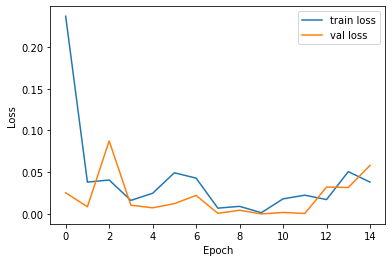

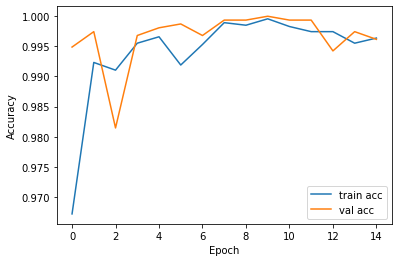

In [23]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

1564/1564 - 37s - loss: 0.0569 - accuracy: 0.9955
Test accuracy: 0.9955242872238159
Test loss: 0.05694052577018738


In [25]:
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc, roc_auc_score

In [26]:
test_generator.reset()
# get the ground truth of your data. 
y_true = test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator, verbose=2)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=1)

# get the classification report
print(classification_report(y_true, y_pred))

1564/1564 - 33s
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       722
           1       1.00      0.99      1.00       842

    accuracy                           1.00      1564
   macro avg       1.00      1.00      1.00      1564
weighted avg       1.00      1.00      1.00      1564



In [27]:
print(confusion_matrix(y_true, y_pred))

[[722   0]
 [  7 835]]


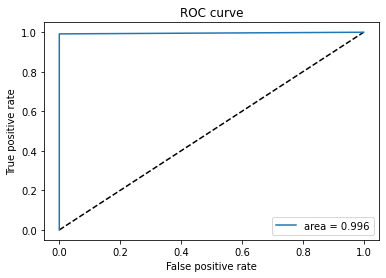

ROC AUC SCORE: 0.9958432304038005


In [28]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print('ROC AUC SCORE:', auc_keras)

In [29]:
from tensorflow.keras.models import load_model

model.save('logs/model_phcinceptionv3.h5')

test accuracy : 99.55242966751918


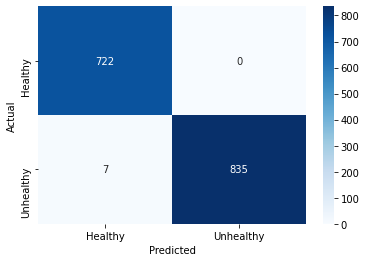

In [30]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('logs/model_phcinceptionv3.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
   X_test,Y_test = test_generator.next()
   y_prob.append(model.predict(X_test))
   y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [3]:
import tensorflow as tf

In [4]:
model = tf.keras.models.load_model('logs/model_phcinceptionv3.h5')

In [5]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [6]:
import skimage

In [7]:
from skimage.transform import resize

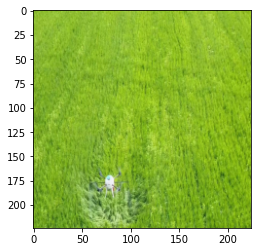

In [8]:
from skimage.transform import resize
new_image = plt.imread('MADApaddy.jpg')
resize_image = resize(new_image, (224,224,3))
img = plt.imshow(resize_image)

In [9]:
predictions = model.predict(np.array([resize_image]))
print(predictions)

[[1.0000000e+00 6.9309385e-11]]


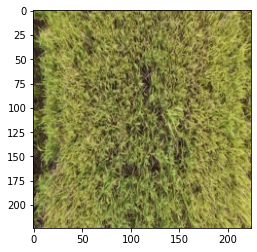

In [14]:
from skimage.transform import resize
new_image = plt.imread('test/Unhealthy/1001u.jpg')
resize_image = resize(new_image, (224,224,3))
img = plt.imshow(resize_image)

In [16]:
predictions = model.predict(np.array([resize_image]))
print(predictions)

[[3.7803072e-19 1.0000000e+00]]


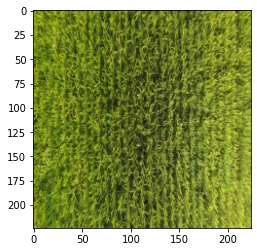

In [19]:
from skimage.transform import resize
new_image = plt.imread('test/Healthy/1000h.jpg')
resize_image = resize(new_image, (224,224,3))
img = plt.imshow(resize_image)

In [20]:
predictions = model.predict(np.array([resize_image]))
print(predictions)

[[1. 0.]]


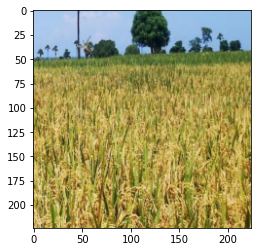

In [21]:
from skimage.transform import resize
new_image = plt.imread('penangkar.jpg')
resize_image = resize(new_image, (224,224,3))
img = plt.imshow(resize_image)

In [22]:
predictions = model.predict(np.array([resize_image]))
print(predictions)

[[9.863529e-17 1.000000e+00]]


In [12]:
img=image.load_img('test/Healthy/1000h.jpg',target_size=(224,224))

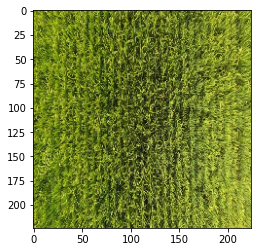

In [13]:
plt.imshow(img)

In [14]:
x=image.img_to_array(img)
x

array([[[109., 128.,  10.],
        [152., 174.,  40.],
        [126., 148.,  14.],
        ...,
        [150., 171.,  40.],
        [148., 167.,  49.],
        [125., 142.,  38.]],

       [[106., 126.,   3.],
        [109., 131.,   0.],
        [128., 149.,  18.],
        ...,
        [172., 191.,  73.],
        [124., 143.,  25.],
        [130., 150.,  29.]],

       [[120., 141.,  12.],
        [124., 147.,   7.],
        [144., 165.,  36.],
        ...,
        [136., 154.,  46.],
        [108., 128.,   7.],
        [164., 186.,  51.]],

       ...,

       [[147., 164.,  60.],
        [ 94., 111.,   9.],
        [165., 182.,  78.],
        ...,
        [197., 208., 104.],
        [126., 138.,  28.],
        [193., 206.,  88.]],

       [[163., 186.,  70.],
        [163., 180.,  66.],
        [186., 200.,  87.],
        ...,
        [168., 179.,  75.],
        [161., 173.,  65.],
        [134., 147.,  31.]],

       [[164., 189.,  62.],
        [143., 162.,  37.],
        [168., 1

In [15]:
x.shape

(224, 224, 3)

In [16]:
x=x/255

In [17]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [18]:
result = model.predict(img_data)
print(result)

[[9.991322e-01 8.678239e-04]]


In [19]:
a=np.argmax(model.predict(img_data), axis=1)

In [20]:
if(a==0):
    print("Healthy")
else:
    print("Unhealthy")

Healthy


[[9.991322e-01 8.678239e-04]]
Healthy


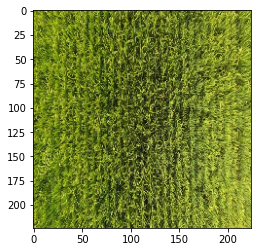

In [23]:
plt.imshow(img)
result = model.predict(img_data)
print(result)

a=np.argmax(model.predict(img_data), axis=1)
if(a==0):
    print("Healthy")
else:
    print("Unhealthy")